# **Import required library**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam # type: ignore
from sklearn.metrics import  accuracy_score

# **Exploring the malware datasets**

Malware dataset is collected on [Kaggle by this link](https://www.kaggle.com/datasets/amauricio/pe-files-malwares) :

*   19611
unique values
*   6051 downloads and gain 135 downloads in the last 30 days
*   Traning model we use record from 0->7900

In [2]:
#import neccessary packages
import pandas as pd
import matplotlib.pyplot as plt

path = "dataset/dataset_malwares_modified.csv"
df = pd.read_csv(path)

In [3]:
# Explore the shape of the dataset
print("The shape of the dataset is: %d samples, %d features" % (df.shape[0], df.shape[1]))

The shape of the dataset is: 19611 samples, 79 features


In [4]:
df.head()

,Name,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,VirusShare_a878ba26000edaac5c98eff4432723b3,23117,144,3,0,4,0,65535,0,184,...,3758096608,0,7,152,0,0,54440,77824,73728,0
1,VirusShare_ef9130570fddc174b312b2047f5f4cf0,23117,144,3,0,4,0,65535,0,184,...,3791650880,0,16,311,0,0,262276,294912,0,346112
2,VirusShare_ef84cdeba22be72a69b198213dada81a,23117,144,3,0,4,0,65535,0,184,...,3221225536,0,6,176,0,0,36864,40960,0,0
3,VirusShare_6bf3608e60ebc16cbcff6ed5467d469e,23117,144,3,0,4,0,65535,0,184,...,3224371328,0,8,155,0,0,356352,1003520,0,14109472
4,VirusShare_2cc94d952b2efb13c7d6bbe0dd59d3fb,23117,144,3,0,4,0,65535,0,184,...,3227516992,0,2,43,0,0,61440,73728,0,90624


# Features selection

* We decide to drop some features that is similar among the dataset.
* We drop down some features that the existence of it does not affect the classification tasks such as LoaderFlags
* Based on the previous works such as [Ember](https://arxiv.org/abs/1804.04637)

In [5]:
selected_columns = ["e_cp", "e_cparhdr", "e_maxalloc", "e_sp", "e_lfanew","Machine", 
                    "NumberOfSections", "TimeDateStamp", "NumberOfSymbols", "SizeOfOptionalHeader",
                    "Characteristics", "Magic", "MajorLinkerVersion", "MinorLinkerVersion", "SizeOfCode",
                    "SizeOfInitializedData", "SizeOfUninitializedData", "AddressOfEntryPoint", "BaseOfCode",
                    "ImageBase", "SectionAlignment", "FileAlignment", "MajorOperatingSystemVersion",
                    "MinorOperatingSystemVersion", "MajorImageVersion", "MinorImageVersion",
                    "MajorSubsystemVersion", "MinorSubsystemVersion", "SizeOfHeaders", "CheckSum", "SizeOfImage",
                    "Subsystem", "DllCharacteristics", "SizeOfStackReserve", "SizeOfStackCommit",
                    "SizeOfHeapReserve", "SizeOfHeapCommit","SuspiciousNameSection", "SuspiciousImportFunctions", "SectionsLength", "SectionMinEntropy", "SectionMinRawsize", "SectionMinVirtualsize", "SectionMaxPhysical", "SectionMaxVirtual", "SectionMaxPointerData", "SectionMaxChar", "DirectoryEntryImport", "DirectoryEntryImportSize", "DirectoryEntryExport", "ImageDirectoryEntryExport", "ImageDirectoryEntryImport"
                    ,"ImageDirectoryEntryResource", "ImageDirectoryEntryException", "ImageDirectoryEntrySecurity","Malware"]

In [6]:
df.shape

(19611, 79)

In [7]:
#get record from 0 to 7900
df = df[selected_columns].iloc[:7900,:]

In [8]:
y = df["Malware"]
x = df.drop(columns = ["Malware"])

In [9]:
y.value_counts()

Malware
1    5498
0    2402
Name: count, dtype: int64

# **Splitting the dataset into test set and train set**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [11]:
y_train.value_counts()

Malware
1    4401
0    1919
Name: count, dtype: int64

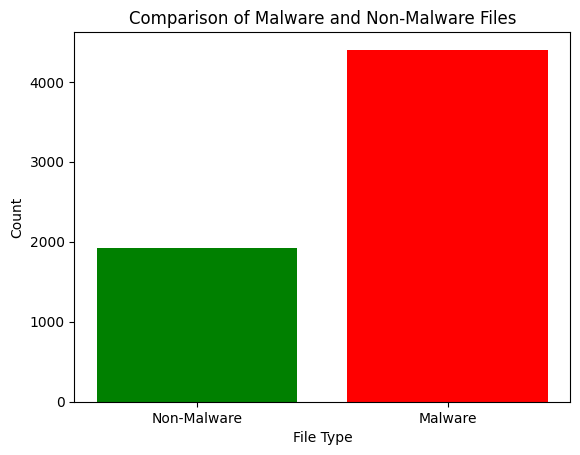

In [12]:
# Calculate counts of malware and non-malware
malware_count =  sum(value for value in y_train if value == 1) # Summing the 1s (which represent malware)
non_malware_count = len(y_train) - malware_count  # Total count minus malware count

# Bar chart
categories = ['Non-Malware', 'Malware']
counts = [non_malware_count, malware_count]

plt.bar(categories, counts, color=['green', 'red'])
plt.xlabel('File Type')
plt.ylabel('Count')
plt.title('Comparison of Malware and Non-Malware Files')
plt.show()
#after plotting the grapth we can see that the data is imbalanced it might cause some
#problems to the model as well

***Deal with imbalanced data***
* Reference: [Deal with imbalanced data](https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100) 

In [13]:
# import necessary libs
from sklearn.utils import resample

In [14]:
from sklearn.utils import resample


# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df[df.Malware==0]
df_minority = df[df.Malware==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Malware.value_counts()

Malware
0    1919
1    1919
Name: count, dtype: int64

In [15]:
y_train_v1 = df_upsampled["Malware"]
x_train_v1 = df_upsampled.drop(columns = ["Malware"])
print("The Malware are remove successfully")

The Malware are remove successfully


In [16]:
#test value of y_train after downscale
y_train_v1.value_counts()

Malware
0    1919
1    1919
Name: count, dtype: int64

# **Train Model with resampling data**

In [17]:
r_model = Sequential()
r_model.add(Dense(55, input_shape=(55,))) # Increase neurons
r_model.add(Dense(55, activation='relu'))  # Add more layers
r_model.add(Dense(36, activation='relu'))  # Add more layers
r_model.add(Dense(25, activation='relu'))  # Add more layers
r_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0015)  # Set learning rate sdirectly
r_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

d:\Federated_Learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
r_model.fit(x_train_v1,y_train_v1,batch_size = 50,epochs = 5)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6866 - loss: 17083902.0000
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7604 - loss: 1857315.8750
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8044 - loss: 6488113.5000
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8072 - loss: 2557292.7500
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7815 - loss: 2400687.2500


***Evaluation on test data***

In [19]:
r_predict = r_model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [20]:
accuracy_score(y_test,r_predict)

0.8981012658227848

***Confusion matrix***

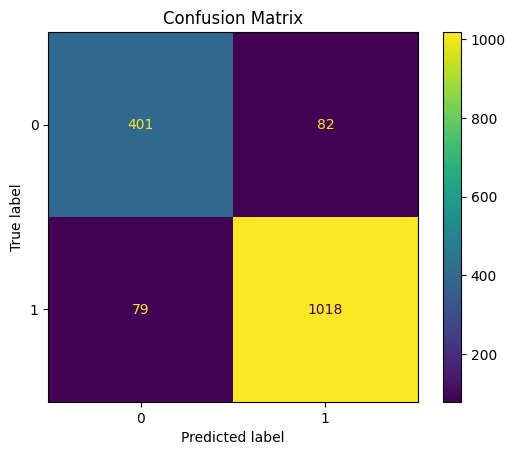

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(
   y_test,r_predict)
cm_display.ax_.set_title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report
# Generate classification report
report_dict = classification_report(y_test, r_predict, output_dict=True)

# Convert the dictionary to a DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Display the classification report DataFrame
print(report_df)

              precision    recall  f1-score      support
0              0.835417  0.830228  0.832814   483.000000
1              0.925455  0.927985  0.926718  1097.000000
accuracy       0.898101  0.898101  0.898101     0.898101
macro avg      0.880436  0.879107  0.879766  1580.000000
weighted avg   0.897930  0.898101  0.898012  1580.000000


***Confusion matrix***

In [23]:
r_model.save("1_save_resampling_model.h5")